In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.applications import ResNet50
import os
from sklearn.metrics import roc_curve, roc_auc_score
import cv2
import matplotlib.pyplot as plt
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tensorflow import keras
import tensorflow
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout,BatchNormalization,GlobalAveragePooling2D,Dropout,MaxPooling2D,Attention,Conv2D,concatenate
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.applications import Xception,VGG16,VGG19,MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.xception import preprocess_input, decode_predictions
from tensorflow.keras.applications.vgg19 import preprocess_input, decode_predictions
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Layer, MultiHeadAttention
from tensorflow.keras.layers import LayerNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, LeakyReLU
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
train_path="/kaggle/input/deepfake-and-real-images/Dataset/Train"
test_path="/kaggle/input/deepfake-and-real-images/Dataset/Test"
val_path="/kaggle/input/deepfake-and-real-images/Dataset/Validation"

In [3]:
import os
import cv2 

def FrameCapture(path): 

    vidObj = cv2.VideoCapture(path) 

    # Used as counter variable 
    count = 0

    success = 1

    if not os.path.exists("frames"):
        os.makedirs("frames")

    while success: 

        # vidObj object calls read 
        # function extract frames 
        success, image = vidObj.read() 

        # Check if the image is empty
        if not success:
            break

        # Saves the frames with frame-count 
        # Modifying to save frames with 'frame' prefix and count as multiples of 10
        frames_num = 20
        if count % frames_num == 0:
            cv2.imwrite("frames/frame%d.jpg" % (count), image) 

        count += 1


In [4]:
FrameCapture("/kaggle/input/test-video") 

In [5]:
train_datagen = ImageDataGenerator( 
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255.0)

# Data Generators
training_set = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),  # Adjusted target size
    batch_size=64,  # Increased batch size
    class_mode='binary'
)

test_set = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),  # Adjusted target size
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

val_set = val_datagen.flow_from_directory(
    val_path,
    target_size=(224, 224),  # Adjusted target size
    batch_size=32,
    class_mode='binary'
)


Found 140002 images belonging to 2 classes.
Found 10905 images belonging to 2 classes.
Found 39428 images belonging to 2 classes.


In [6]:
from tensorflow.keras.layers import LSTM, TimeDistributed
# Define the LSTM configuration
from tensorflow.keras.layers import Reshape
lstm_units = 64  # Adjust as needed

# Define the CNN part of the model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
cnn_output = Dense(16, activation='relu')(x)

# Reshape CNN output to fit LSTM input
reshaped_cnn_output = Reshape((1, 16))(cnn_output)  # Assuming output shape of Dense layer is (None, 16)

# Define the LSTM layer
lstm_layer = LSTM(units=lstm_units)

# Apply LSTM to the reshaped CNN output
lstm_output = lstm_layer(reshaped_cnn_output)

# Output layer
predictions = Dense(1, activation='sigmoid')(lstm_output)

# Combine the models
combined_model = Model(inputs=base_model.input, outputs=predictions)

94765736/94765736 [==============================] - 0s 0us/step


In [7]:
#combined_model.summary()

In [8]:
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)
combined_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


In [9]:
combined_model.compile(optimizer=optimizer, loss='binary_crossentropy',
              metrics=['accuracy'])

In [10]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [11]:
with tf.device('/GPU:1'):
    history = combined_model.fit(
        training_set,
        epochs=15,
        validation_data=val_set
    )


Epoch 1/15
2188/2188 [==============================] - 2675s 1s/step - loss: 0.6871 - accuracy: 0.5517 - val_loss: 0.6885 - val_accuracy: 0.5490
Epoch 2/15
2188/2188 [==============================] - 1909s 872ms/step - loss: 0.6757 - accuracy: 0.5783 - val_loss: 0.6805 - val_accuracy: 0.5672
Epoch 3/15
2188/2188 [==============================] - 1920s 878ms/step - loss: 0.6696 - accuracy: 0.5906 - val_loss: 0.6697 - val_accuracy: 0.5934
Epoch 4/15
2188/2188 [==============================] - 1937s 885ms/step - loss: 0.6640 - accuracy: 0.6025 - val_loss: 0.6665 - val_accuracy: 0.5904
Epoch 5/15
2188/2188 [==============================] - 1976s 903ms/step - loss: 0.6619 - accuracy: 0.6053 - val_loss: 0.6662 - val_accuracy: 0.5870
Epoch 6/15
2188/2188 [==============================] - 1948s 890ms/step - loss: 0.6606 - accuracy: 0.6073 - val_loss: 0.6539 - val_accuracy: 0.6195
Epoch 7/15
2188/2188 [==============================] - 1964s 898ms/step - loss: 0.6593 - accuracy: 0.6092 - 

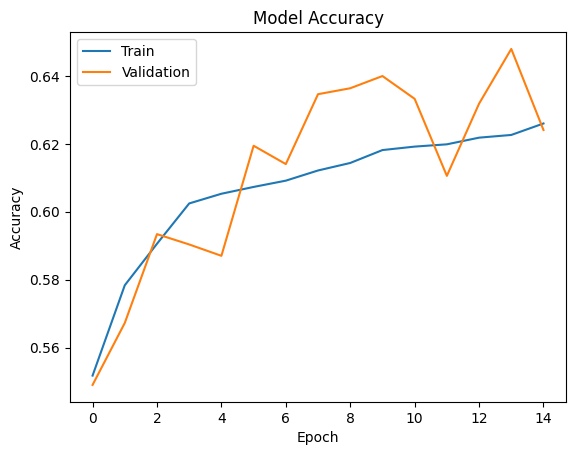

In [12]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

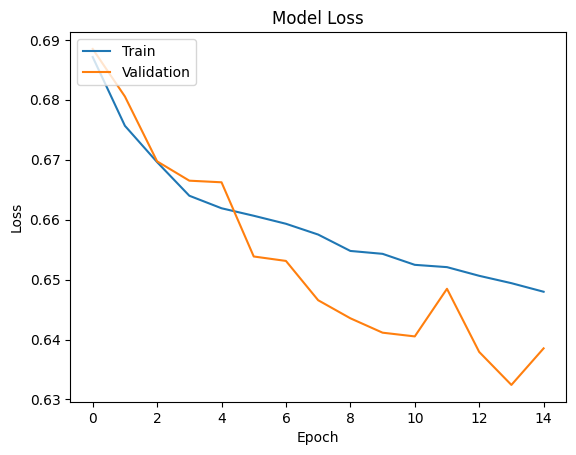

In [13]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [14]:
# Predict the classes using the test set
test_pred = combined_model.predict(test_set)
test_pred_classes = np.round(test_pred)

# Get the true classes of the test set
test_true_classes = test_set.classes

341/341 [==============================] - 73s 211ms/step


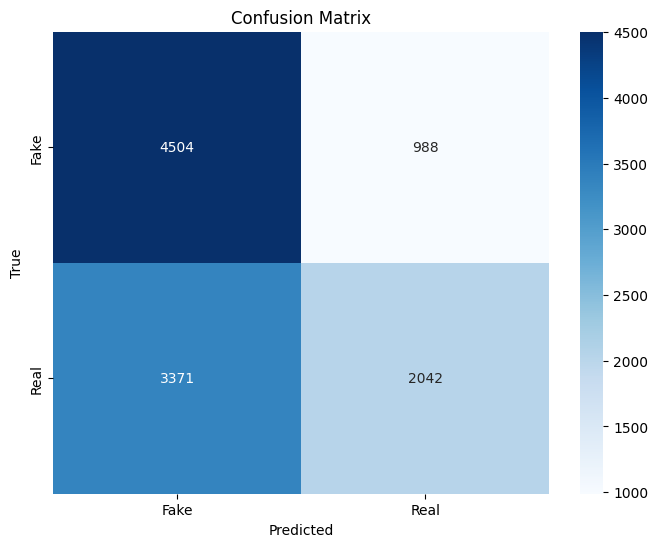

In [15]:
# Plot confusion matrix as a heatmap
# Generate confusion matrix
cm = confusion_matrix(test_true_classes, test_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_set.class_indices.keys(),
            yticklabels=test_set.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [16]:
evaluation = combined_model.evaluate(test_set)

341/341 [==============================] - 22s 65ms/step - loss: 0.6723 - accuracy: 0.6003


In [17]:
print("Test Accuracy: {:.2f}%".format(evaluation[1] * 100))

Test Accuracy: 60.03%


In [18]:
#Classification report
report = classification_report(test_true_classes, test_pred_classes, target_names=["Class 0", "Class 1"], labels=[0, 1], digits=4)

print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

     Class 0     0.5719    0.8201    0.6739      5492
     Class 1     0.6739    0.3772    0.4837      5413

    accuracy                         0.6003     10905
   macro avg     0.6229    0.5987    0.5788     10905
weighted avg     0.6226    0.6003    0.5795     10905



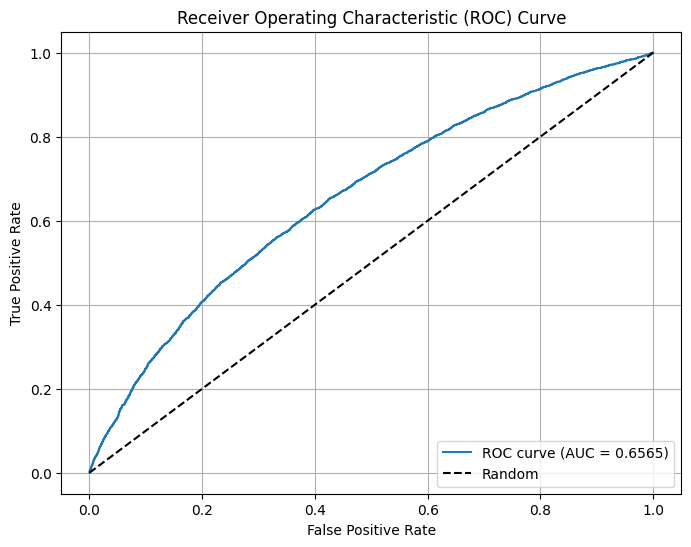

In [19]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(test_true_classes, test_pred)

# Calculate AUC
auc = roc_auc_score(test_true_classes, test_pred)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.4f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

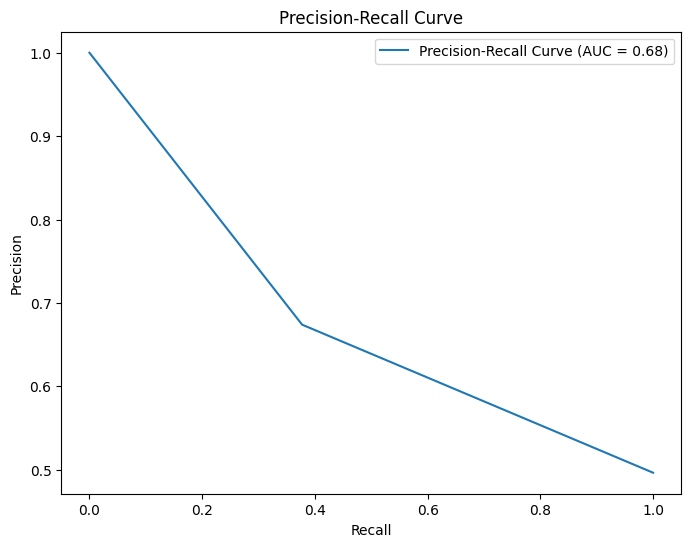

In [20]:
from sklearn.metrics import precision_recall_curve, auc
# Compute precision and recall
precision, recall, thresholds = precision_recall_curve(test_true_classes, test_pred_classes)

# Calculate the area under the precision-recall curve (AUC-PR)
auc_pr = auc(recall, precision)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall Curve (AUC = {auc_pr:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [21]:
# Compute confusion matrix
tn, fp, fn, tp = confusion_matrix(test_true_classes, test_pred_classes).ravel()

# Calculate sensitivity and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f'Sensitivity (True Positive Rate): {sensitivity:.4f}')
print(f'Specificity (True Negative Rate): {specificity:.4f}')

Sensitivity (True Positive Rate): 0.3772
Specificity (True Negative Rate): 0.8201


In [22]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

# Assuming you have obtained test_pred_classes and test_true_classes as described earlier

# Calculate F1 score for the test classes
f1 = f1_score(test_true_classes, test_pred_classes)
# Calculate accuracy to get error rate
accuracy = accuracy_score(test_true_classes, test_pred_classes)
error_rate = 1 - accuracy
# Calculate G-mean
g_mean = (sensitivity * specificity) ** 0.5

# Calculate F-measure
f_measure = 2 * ((sensitivity * specificity) / (sensitivity + specificity))

print(f'F1 Score: {f1:.4f}')
print(f'Error Rate: {error_rate:.4f}')
print(f'G-mean: {g_mean:.4f}')
print(f'F-measure: {f_measure:.4f}')

F1 Score: 0.4837
Error Rate: 0.3997
G-mean: 0.5562
F-measure: 0.5168


In [23]:
import requests
from PIL import Image
from io import BytesIO

# image_url = "https://assets.bwbx.io/images/users/iqjWHBFdfxIU/irCSqgfWvpSw/v1/-1x-1.jpg"
image_url = "https://cdn.britannica.com/86/182086-050-5FB81069/singer-Taylor-swift-2013.jpg"
response = requests.get(image_url)
img = Image.open(BytesIO(response.content))


In [24]:
img = img.resize((224, 224))  # Adjust size according to your model
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalize pixel values


In [25]:
prediction = combined_model.predict(img_array)
if prediction[0][0] >= 0.5:
    print("The image is predicted as a deepfake.")
else:
    print("The image is predicted as real.")


1/1 [==============================] - 2s 2s/step
The image is predicted as real.


In [26]:
# Save the model
model_save_path = "deepfake_detection_model.h5"
combined_model.save(model_save_path)
print("Model saved at:", model_save_path)


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved at: deepfake_detection_model.h5
